In [147]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats
from scipy.special import boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

import lightgbm as lgb
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [148]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [149]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [150]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


list(filter(lambda x: x not in col_obj, train.columns[train.dtypes==object]))

for col in col_obj:
    print(train.groupby(col, as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False))

for col in list(filter(lambda x: x not in col_obj, train.columns[train.dtypes==object])):
    print(train.groupby(col, as_index=False)['SalePrice'].mean().sort_values(by='SalePrice', ascending=False))

In [151]:
train.drop(train[train['GrLivArea']>4600].index, inplace=True)

In [152]:
y_train = train['SalePrice'].values

y_train_log = np.log(y_train)

In [153]:
train.drop(['SalePrice'], axis=1, inplace=True)

In [154]:
test_id = test['Id'].values

In [155]:
del train['Id'], test['Id']

In [156]:
all_data = pd.concat([train, test], axis=0)

In [157]:
all_data.shape

(2917, 79)

In [158]:
all_data_skew = all_data[all_data.columns[train.dtypes!=object]].skew()
skewed_columns = all_data_skew.index[all_data_skew.abs()>0.75]

In [159]:
skewed_columns.shape

(20,)

In [160]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageCond,159,0.054508
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508


In [161]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")


all_data['GarageYrBlt'].fillna(0, inplace=True)

all_data['MasVnrArea'].fillna(all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median(), inplace=True)

all_data['LotFrontage'].fillna(all_data['LotFrontage'].median(), inplace=True)


del all_data['Utilities']

In [162]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [163]:
#all_data['OverallQual'] = all_data['OverallQual'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [164]:
col_obj = all_data.columns[all_data.dtypes==object]
col_num = all_data.columns[all_data.dtypes!=object]
print(len(col_obj))
print(len(col_num))

46
33


In [165]:
col_obj = all_data.columns[all_data.dtypes==object]
col_num = all_data.columns[all_data.dtypes!=object]
print(len(col_obj))
print(len(col_num))

46
33


In [166]:
col_obj = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

for col in col_obj:
    all_data[col] = all_data[col].factorize()[0]

In [167]:
from sklearn.preprocessing import LabelEncoder

for col in col_obj:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[col].values)) 
    all_data[col] = lbl.transform(list(all_data[col].values))

In [168]:
all_data.shape

(2917, 79)

In [169]:
len(col_obj)

26

In [170]:
train.describe(include='O').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [171]:
all_data_skew = all_data[col_num].skew()
skewed_columns = all_data_skew[all_data_skew.abs()>0.75].index

In [172]:
for col in skewed_columns:
    lam = 0.15
    all_data[col] = boxcox1p(all_data[col], lam)

In [173]:
#all_data[col_obj] = all_data[col_obj].astype(str)
all_data = pd.get_dummies(all_data)

In [174]:
all_data.shape

(2917, 220)

In [175]:
all_data.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,TotalSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,...,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,10,5.831328,19.212182,1,1,3,0,7,4,2003,2003,8.059126,2,4,2,4,3,2,11.170327,6,0.0,7.483296,856.0,0,1,11.692623,11.686189,0.0,13.698888,1.0,0.000000,2,1,3,0.730463,2,8,6,0,3,14.187527,2,2.0,548.0,5,5,2,0.000000,5.714669,0.000000,0.0,0.0,0.0,3,4,0.0,4,2,14.976591,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,5,6.221214,19.712205,1,1,3,0,6,7,1976,1976,0.000000,3,4,2,4,1,0,12.062832,6,0.0,8.897844,1262.0,0,1,12.792276,0.000000,0.0,12.792276,0.0,0.730463,2,0,3,0.730463,3,6,6,1,5,14.145138,2,2.0,460.0,5,5,2,9.010206,0.000000,0.000000,0.0,0.0,0.0,3,4,0.0,7,1,14.923100,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0

In [176]:
len(col_num)

33

In [177]:
pd.Series(all_data.columns)

0                 MSSubClass
1                LotFrontage
2                    LotArea
3                     Street
4                      Alley
5                   LotShape
6                  LandSlope
7                OverallQual
8                OverallCond
9                  YearBuilt
10              YearRemodAdd
11                MasVnrArea
12                 ExterQual
13                 ExterCond
14                  BsmtQual
15                  BsmtCond
16              BsmtExposure
17              BsmtFinType1
18                BsmtFinSF1
19              BsmtFinType2
20                BsmtFinSF2
21                 BsmtUnfSF
22               TotalBsmtSF
23                 HeatingQC
24                CentralAir
25                  1stFlrSF
26                  2ndFlrSF
27              LowQualFinSF
28                 GrLivArea
29              BsmtFullBath
30              BsmtHalfBath
31                  FullBath
32                  HalfBath
33              BedroomAbvGr
34            

In [178]:
all_data.fillna(all_data.mean(), inplace=True)

In [179]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

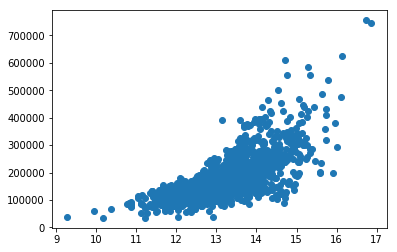

In [180]:
plt.scatter(x=train['GrLivArea'], y=y_train)

In [181]:
train.shape

(1458, 220)

In [182]:
train.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,TotalSF,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,...,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,10,5.831328,19.212182,1,1,3,0,7,4,2003,2003,8.059126,2,4,2,4,3,2,11.170327,6,0.0,7.483296,856.0,0,1,11.692623,11.686189,0.0,13.698888,1.0,0.000000,2,1,3,0.730463,2,8,6,0,3,14.187527,2,2.0,548.0,5,5,2,0.000000,5.714669,0.000000,0.0,0.0,0.0,3,4,0.0,4,2,14.976591,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,5,6.221214,19.712205,1,1,3,0,6,7,1976,1976,0.000000,3,4,2,4,1,0,12.062832,6,0.0,8.897844,1262.0,0,1,12.792276,0.000000,0.0,12.792276,0.0,0.730463,2,0,3,0.730463,3,6,6,1,5,14.145138,2,2.0,460.0,5,5,2,9.010206,0.000000,0.000000,0.0,0.0,0.0,3,4,0.0,7,1,14.923100,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0

In [183]:
n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=42)

In [184]:
def rmse_cv(model, train):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train)
    rmse= np.sqrt(-cross_val_score(model,train, y_train_log, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [185]:
ss = StandardScaler()
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

In [195]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso

In [197]:
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train_log, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1105 (0.0070)



In [186]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005, 0.000425, 0.000422, 0.000423], n_jobs=-1).fit(train_ss, y_train_log)
print(rmse_cv(model_lasso, train_ss).mean())
print(model_lasso.alpha_)

0.1142757765589408
0.001


coef = pd.Series(model_lasso.coef_, index = train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

coef[np.abs(coef)>0].sort_values(ascending=False)

dropf = coef.loc[coef==0].index
train = train.drop(dropf, axis=1)
test = test.drop(dropf, axis=1)

ss = StandardScaler()
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

from sklearn.linear_model import LinearRegression, Lasso

reg_lasso = []
val_rmse_lasso = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.001).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

coef = pd.Series(model_lasso.coef_, index = train.columns)

coef

dropf = coef.loc[coef==0].index
print(dropf)

In [187]:
#train = train.drop(dropf, axis=1)

coef.sort_values(ascending=False)

In [188]:
lgb_params = {
               'feature_fraction': 0.75,
               'max_depth': 3,
               'metric': 'rmse',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'mse', 
               'num_leaves': 2**4,
               'verbose':0 
              }

In [189]:
reg = []
val_rmse = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train.iloc[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train.iloc[val_idx, :], y_train_log[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=100)
    pred_lgb = model_lgb.predict(X_val)
    val_rmse.append(np.sqrt(mean_squared_error(y_val, pred_lgb)))
    reg.append(model_lgb)

[1]	valid_0's rmse: 0.380969
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.354102
[3]	valid_0's rmse: 0.330125
[4]	valid_0's rmse: 0.310183
[5]	valid_0's rmse: 0.292301
[6]	valid_0's rmse: 0.276952
[7]	valid_0's rmse: 0.262158
[8]	valid_0's rmse: 0.250268
[9]	valid_0's rmse: 0.238612
[10]	valid_0's rmse: 0.228793
[11]	valid_0's rmse: 0.219292
[12]	valid_0's rmse: 0.210699
[13]	valid_0's rmse: 0.204215
[14]	valid_0's rmse: 0.197794
[15]	valid_0's rmse: 0.191428
[16]	valid_0's rmse: 0.186303
[17]	valid_0's rmse: 0.181064
[18]	valid_0's rmse: 0.177146
[19]	valid_0's rmse: 0.173617
[20]	valid_0's rmse: 0.170285
[21]	valid_0's rmse: 0.167435
[22]	valid_0's rmse: 0.164012
[23]	valid_0's rmse: 0.161227
[24]	valid_0's rmse: 0.15894
[25]	valid_0's rmse: 0.156861
[26]	valid_0's rmse: 0.154874
[27]	valid_0's rmse: 0.153533
[28]	valid_0's rmse: 0.15231
[29]	valid_0's rmse: 0.150514
[30]	valid_0's rmse: 0.148775
[31]	valid_0's rmse: 0.147142
[32]	valid_0's rms

[284]	valid_0's rmse: 0.109471
[285]	valid_0's rmse: 0.109481
[286]	valid_0's rmse: 0.109464
[287]	valid_0's rmse: 0.109519
[288]	valid_0's rmse: 0.109549
[289]	valid_0's rmse: 0.109472
[290]	valid_0's rmse: 0.109459
[291]	valid_0's rmse: 0.109499
[292]	valid_0's rmse: 0.109493
[293]	valid_0's rmse: 0.109627
[294]	valid_0's rmse: 0.109626
[295]	valid_0's rmse: 0.109651
[296]	valid_0's rmse: 0.10957
[297]	valid_0's rmse: 0.109803
[298]	valid_0's rmse: 0.109842
[299]	valid_0's rmse: 0.109803
[300]	valid_0's rmse: 0.109889
[301]	valid_0's rmse: 0.109872
[302]	valid_0's rmse: 0.10991
[303]	valid_0's rmse: 0.109871
[304]	valid_0's rmse: 0.109858
[305]	valid_0's rmse: 0.109789
[306]	valid_0's rmse: 0.109784
[307]	valid_0's rmse: 0.109743
[308]	valid_0's rmse: 0.109724
[309]	valid_0's rmse: 0.109753
[310]	valid_0's rmse: 0.109748
[311]	valid_0's rmse: 0.109765
[312]	valid_0's rmse: 0.109736
[313]	valid_0's rmse: 0.109764
[314]	valid_0's rmse: 0.109866
[315]	valid_0's rmse: 0.109902
[316]	vali

[275]	valid_0's rmse: 0.124397
[276]	valid_0's rmse: 0.124408
[277]	valid_0's rmse: 0.124415
[278]	valid_0's rmse: 0.124316
[279]	valid_0's rmse: 0.124345
[280]	valid_0's rmse: 0.124299
[281]	valid_0's rmse: 0.124174
[282]	valid_0's rmse: 0.124192
[283]	valid_0's rmse: 0.124241
[284]	valid_0's rmse: 0.124226
[285]	valid_0's rmse: 0.124305
[286]	valid_0's rmse: 0.124348
[287]	valid_0's rmse: 0.124466
[288]	valid_0's rmse: 0.124437
[289]	valid_0's rmse: 0.12442
[290]	valid_0's rmse: 0.12445
[291]	valid_0's rmse: 0.124372
[292]	valid_0's rmse: 0.124344
[293]	valid_0's rmse: 0.124302
[294]	valid_0's rmse: 0.124281
[295]	valid_0's rmse: 0.124337
[296]	valid_0's rmse: 0.124371
[297]	valid_0's rmse: 0.124357
[298]	valid_0's rmse: 0.124331
[299]	valid_0's rmse: 0.124281
[300]	valid_0's rmse: 0.124303
[301]	valid_0's rmse: 0.124275
[302]	valid_0's rmse: 0.124228
[303]	valid_0's rmse: 0.12422
[304]	valid_0's rmse: 0.12418
[305]	valid_0's rmse: 0.124147
[306]	valid_0's rmse: 0.124125
[307]	valid_

[139]	valid_0's rmse: 0.132397
[140]	valid_0's rmse: 0.132198
[141]	valid_0's rmse: 0.132196
[142]	valid_0's rmse: 0.132096
[143]	valid_0's rmse: 0.13202
[144]	valid_0's rmse: 0.131891
[145]	valid_0's rmse: 0.131844
[146]	valid_0's rmse: 0.131965
[147]	valid_0's rmse: 0.131881
[148]	valid_0's rmse: 0.131891
[149]	valid_0's rmse: 0.131795
[150]	valid_0's rmse: 0.131676
[151]	valid_0's rmse: 0.131646
[152]	valid_0's rmse: 0.13162
[153]	valid_0's rmse: 0.131633
[154]	valid_0's rmse: 0.131629
[155]	valid_0's rmse: 0.131489
[156]	valid_0's rmse: 0.131571
[157]	valid_0's rmse: 0.131393
[158]	valid_0's rmse: 0.131417
[159]	valid_0's rmse: 0.131405
[160]	valid_0's rmse: 0.131249
[161]	valid_0's rmse: 0.13136
[162]	valid_0's rmse: 0.131257
[163]	valid_0's rmse: 0.131344
[164]	valid_0's rmse: 0.131361
[165]	valid_0's rmse: 0.131311
[166]	valid_0's rmse: 0.131305
[167]	valid_0's rmse: 0.131204
[168]	valid_0's rmse: 0.131171
[169]	valid_0's rmse: 0.131075
[170]	valid_0's rmse: 0.13109
[171]	valid_

[405]	valid_0's rmse: 0.129484
[406]	valid_0's rmse: 0.129518
[407]	valid_0's rmse: 0.129531
[408]	valid_0's rmse: 0.129535
[409]	valid_0's rmse: 0.129588
[410]	valid_0's rmse: 0.129593
[411]	valid_0's rmse: 0.129566
[412]	valid_0's rmse: 0.129527
[413]	valid_0's rmse: 0.129493
[414]	valid_0's rmse: 0.129486
[415]	valid_0's rmse: 0.129505
[416]	valid_0's rmse: 0.129516
[417]	valid_0's rmse: 0.129558
[418]	valid_0's rmse: 0.129502
[419]	valid_0's rmse: 0.129513
[420]	valid_0's rmse: 0.129546
[421]	valid_0's rmse: 0.129556
[422]	valid_0's rmse: 0.129505
[423]	valid_0's rmse: 0.129543
[424]	valid_0's rmse: 0.129519
[425]	valid_0's rmse: 0.12956
[426]	valid_0's rmse: 0.129619
[427]	valid_0's rmse: 0.129611
[428]	valid_0's rmse: 0.129582
[429]	valid_0's rmse: 0.129576
[430]	valid_0's rmse: 0.129548
[431]	valid_0's rmse: 0.129532
[432]	valid_0's rmse: 0.129558
[433]	valid_0's rmse: 0.129543
[434]	valid_0's rmse: 0.129548
[435]	valid_0's rmse: 0.129513
[436]	valid_0's rmse: 0.129553
[437]	val

In [190]:
np.sum(val_rmse)/n_folds

0.11854871952164658

In [191]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [192]:
score = rmse_cv(model_lgb, train)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1162 (0.0063)



In [ ]:
0.1217319774354018

In [198]:
feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance()

In [199]:
importance = pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)
importance

,Importance
LotArea,109.4
TotalSF,106.8
GrLivArea,86.4
GarageArea,75.0
YearBuilt,73.8
1stFlrSF,72.8
BsmtUnfSF,65.0
OverallQual,64.2
GarageYrBlt,62.2
TotalBsmtSF,56.8


In [ ]:
dropf = importance[importance['Importance']==0].index
train = train.drop(dropf, axis=1)
test = test.drop(dropf, axis=1)

In [200]:
reg = []
val_rmse = []

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train.iloc[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train.iloc[val_idx, :], y_train_log[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=100)
    pred_lgb = model_lgb.predict(X_val)
    val_rmse.append(np.sqrt(mean_squared_error(y_val, pred_lgb)))
    reg.append(model_lgb)

[1]	valid_0's rmse: 0.380969
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.354102
[3]	valid_0's rmse: 0.330125
[4]	valid_0's rmse: 0.310183
[5]	valid_0's rmse: 0.292301
[6]	valid_0's rmse: 0.276952
[7]	valid_0's rmse: 0.262158
[8]	valid_0's rmse: 0.250268
[9]	valid_0's rmse: 0.238612
[10]	valid_0's rmse: 0.228793
[11]	valid_0's rmse: 0.219292
[12]	valid_0's rmse: 0.210699
[13]	valid_0's rmse: 0.204215
[14]	valid_0's rmse: 0.197794
[15]	valid_0's rmse: 0.191428
[16]	valid_0's rmse: 0.186303
[17]	valid_0's rmse: 0.181064
[18]	valid_0's rmse: 0.177146
[19]	valid_0's rmse: 0.173617
[20]	valid_0's rmse: 0.170285
[21]	valid_0's rmse: 0.167435
[22]	valid_0's rmse: 0.164012
[23]	valid_0's rmse: 0.161227
[24]	valid_0's rmse: 0.15894
[25]	valid_0's rmse: 0.156861
[26]	valid_0's rmse: 0.154874
[27]	valid_0's rmse: 0.153533
[28]	valid_0's rmse: 0.15231
[29]	valid_0's rmse: 0.150514
[30]	valid_0's rmse: 0.148775
[31]	valid_0's rmse: 0.147142
[32]	valid_0's rms

[259]	valid_0's rmse: 0.109951
[260]	valid_0's rmse: 0.109941
[261]	valid_0's rmse: 0.109903
[262]	valid_0's rmse: 0.109846
[263]	valid_0's rmse: 0.109844
[264]	valid_0's rmse: 0.109825
[265]	valid_0's rmse: 0.109795
[266]	valid_0's rmse: 0.10979
[267]	valid_0's rmse: 0.109787
[268]	valid_0's rmse: 0.109769
[269]	valid_0's rmse: 0.109736
[270]	valid_0's rmse: 0.109832
[271]	valid_0's rmse: 0.109817
[272]	valid_0's rmse: 0.109816
[273]	valid_0's rmse: 0.109777
[274]	valid_0's rmse: 0.109728
[275]	valid_0's rmse: 0.109709
[276]	valid_0's rmse: 0.109707
[277]	valid_0's rmse: 0.109698
[278]	valid_0's rmse: 0.109588
[279]	valid_0's rmse: 0.109594
[280]	valid_0's rmse: 0.109572
[281]	valid_0's rmse: 0.109527
[282]	valid_0's rmse: 0.109513
[283]	valid_0's rmse: 0.109466
[284]	valid_0's rmse: 0.109471
[285]	valid_0's rmse: 0.109481
[286]	valid_0's rmse: 0.109464
[287]	valid_0's rmse: 0.109519
[288]	valid_0's rmse: 0.109549
[289]	valid_0's rmse: 0.109472
[290]	valid_0's rmse: 0.109459
[291]	val

[254]	valid_0's rmse: 0.124452
[255]	valid_0's rmse: 0.124396
[256]	valid_0's rmse: 0.124411
[257]	valid_0's rmse: 0.124461
[258]	valid_0's rmse: 0.124432
[259]	valid_0's rmse: 0.124423
[260]	valid_0's rmse: 0.124382
[261]	valid_0's rmse: 0.124423
[262]	valid_0's rmse: 0.124385
[263]	valid_0's rmse: 0.124337
[264]	valid_0's rmse: 0.124305
[265]	valid_0's rmse: 0.124409
[266]	valid_0's rmse: 0.124432
[267]	valid_0's rmse: 0.124403
[268]	valid_0's rmse: 0.124419
[269]	valid_0's rmse: 0.124345
[270]	valid_0's rmse: 0.124337
[271]	valid_0's rmse: 0.124344
[272]	valid_0's rmse: 0.124389
[273]	valid_0's rmse: 0.124398
[274]	valid_0's rmse: 0.124398
[275]	valid_0's rmse: 0.124397
[276]	valid_0's rmse: 0.124408
[277]	valid_0's rmse: 0.124415
[278]	valid_0's rmse: 0.124316
[279]	valid_0's rmse: 0.124345
[280]	valid_0's rmse: 0.124299
[281]	valid_0's rmse: 0.124174
[282]	valid_0's rmse: 0.124192
[283]	valid_0's rmse: 0.124241
[284]	valid_0's rmse: 0.124226
[285]	valid_0's rmse: 0.124305
[286]	va

[184]	valid_0's rmse: 0.131113
[185]	valid_0's rmse: 0.131107
[186]	valid_0's rmse: 0.131148
[187]	valid_0's rmse: 0.131127
[188]	valid_0's rmse: 0.131166
[189]	valid_0's rmse: 0.131071
[190]	valid_0's rmse: 0.131106
[191]	valid_0's rmse: 0.131074
[192]	valid_0's rmse: 0.131065
[193]	valid_0's rmse: 0.131039
[194]	valid_0's rmse: 0.131208
[195]	valid_0's rmse: 0.131237
[196]	valid_0's rmse: 0.13124
[197]	valid_0's rmse: 0.131306
[198]	valid_0's rmse: 0.131409
[199]	valid_0's rmse: 0.13144
[200]	valid_0's rmse: 0.131373
[201]	valid_0's rmse: 0.131315
[202]	valid_0's rmse: 0.131286
[203]	valid_0's rmse: 0.131343
[204]	valid_0's rmse: 0.131301
[205]	valid_0's rmse: 0.131085
[206]	valid_0's rmse: 0.131092
[207]	valid_0's rmse: 0.131225
[208]	valid_0's rmse: 0.13127
[209]	valid_0's rmse: 0.131233
[210]	valid_0's rmse: 0.131164
[211]	valid_0's rmse: 0.131268
[212]	valid_0's rmse: 0.131275
[213]	valid_0's rmse: 0.131255
[214]	valid_0's rmse: 0.131238
[215]	valid_0's rmse: 0.131308
[216]	valid

[25]	valid_0's rmse: 0.137687
[26]	valid_0's rmse: 0.135599
[27]	valid_0's rmse: 0.133617
[28]	valid_0's rmse: 0.131761
[29]	valid_0's rmse: 0.130296
[30]	valid_0's rmse: 0.129632
[31]	valid_0's rmse: 0.128323
[32]	valid_0's rmse: 0.127063
[33]	valid_0's rmse: 0.126237
[34]	valid_0's rmse: 0.125609
[35]	valid_0's rmse: 0.124825
[36]	valid_0's rmse: 0.124076
[37]	valid_0's rmse: 0.123387
[38]	valid_0's rmse: 0.122726
[39]	valid_0's rmse: 0.122015
[40]	valid_0's rmse: 0.121846
[41]	valid_0's rmse: 0.120953
[42]	valid_0's rmse: 0.12055
[43]	valid_0's rmse: 0.119816
[44]	valid_0's rmse: 0.119021
[45]	valid_0's rmse: 0.118916
[46]	valid_0's rmse: 0.117751
[47]	valid_0's rmse: 0.117072
[48]	valid_0's rmse: 0.116955
[49]	valid_0's rmse: 0.116277
[50]	valid_0's rmse: 0.116295
[51]	valid_0's rmse: 0.11637
[52]	valid_0's rmse: 0.116166
[53]	valid_0's rmse: 0.115909
[54]	valid_0's rmse: 0.115775
[55]	valid_0's rmse: 0.11523
[56]	valid_0's rmse: 0.115048
[57]	valid_0's rmse: 0.114511
[58]	valid_0'

In [201]:
np.sum(val_rmse)/n_folds

0.11854871952164658

In [ ]:
feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance()

In [ ]:
importance = pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)
importance

feature_imp = np.zeros(train.shape[1])
for model in reg:
    feature_imp+=model.feature_importance(importance_type='gain')

importance = pd.DataFrame({'Importance':feature_imp/n_folds}, index=train.columns).sort_values(by='Importance', ascending=False)
importance

In [202]:
ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

C = [10**i for i in range(0,3)]
epsilon = [10**i for i in range(-4,-1)]
gamma = [10**i for i in range(-5,-2)]

tuned_parameters = {'C':C, 'epsilon':epsilon, 'gamma':gamma}

svr = RandomizedSearchCV(
    SVR(), # 識別器
    tuned_parameters, # 最適化したいパラメータセット
    n_iter = 20, 
    n_jobs = -1,
    cv=4, # 交差検定の回数
    scoring='neg_mean_squared_error') # モデルの評価関数の指定


svr.fit(train_ss, y_train_log)
print(np.sqrt(-svr.best_score_))
print(svr.best_params_)

0.11156245833278153
{'gamma': 0.0001, 'epsilon': 0.001, 'C': 100}


In [203]:
preds_svr = svr.predict(test_ss)

drop_f2 = importance[importance['Importance']==0].index

for df in [train, test]:
    df = df.drop(drop_f2, axis=1)

train = train.drop(drop_f2, axis=1)

test = test.drop(dropf, axis=1)
test = test.drop(drop_f2, axis=1)

In [204]:
reg_lasso = []
val_rmse_lasso = []

ss.fit(train)
train_ss = ss.transform(train)
test_ss = ss.transform(test)

for train_idx, val_idx in kf.split(train):
    X_tr, y_tr = train_ss[train_idx, :], y_train_log[train_idx]
    X_val, y_val = train_ss[val_idx, :], y_train_log[val_idx]
    
    model_lasso = Lasso(alpha=0.001).fit(X_tr, y_tr)
    pred_lasso = model_lasso.predict(X_val)
    val_rmse_lasso.append(np.sqrt(mean_squared_error(y_val, pred_lasso)))
    reg_lasso.append(model_lasso)

print(np.sum(val_rmse_lasso)/n_folds)

0.11737482323398085


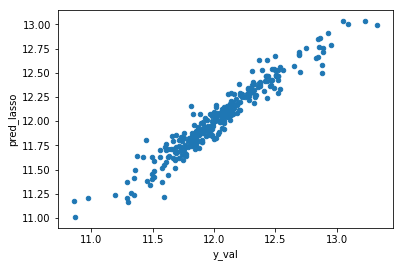

In [205]:
predictions = pd.DataFrame({"y_val":y_val, "pred_lasso":pred_lasso})
predictions.plot(x = "y_val", y = "pred_lasso", kind = "scatter")

In [206]:
preds_lasso = None

for model in reg_lasso:
    if preds_lasso is None:
        preds_lasso = model.predict(test_ss) / n_folds
    else:
        preds_lasso += model.predict(test_ss) / n_folds

In [207]:
preds_lgb = None

for model in reg:
    if preds_lgb is None:
        preds_lgb = model.predict(test) / n_folds
    else:
        preds_lgb += model.predict(test) / n_folds

In [208]:
np.exp((preds_lasso+preds_svr+preds_lgb)/3)

array([122855.49014574, 162135.16899187, 186507.56066004, ...,
       171700.71067901, 121096.3021861 , 222380.80007051])

preds = None

for model in reg:
    if preds is None:
        preds = model.predict(test) / n_folds
    else:
        preds += model.predict(test) / n_folds

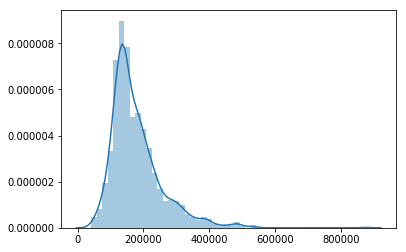

In [209]:
sns.distplot(np.exp((preds_lasso+preds_svr+preds_lgb)/3))

In [211]:
solution = pd.DataFrame({"id":test_id, "SalePrice":np.exp((preds_lasso+preds_svr+preds_lgb)/3)})
solution.to_csv("submission_43.csv", index = False)